# Clustering Cihan

In [37]:
import pandas as pd
import numpy as np     
import matplotlib.pyplot as plt
import seaborn as sns

fragmenten_df = pd.read_csv('Data/fragments_data.csv')
birchFragmenten_df = fragmenten_df.copy()
birchFragmenten_df.head()

,fragment,labels,label_numeric
0,05190.100417.watersniproepEempolder_fragment_0...,watersnip,0
1,05190.100417.watersniproepEempolder_fragment_1...,watersnip,0
2,05190.100417.watersniproepEempolder_fragment_2...,watersnip,0
3,05190.100417.watersniproepEempolder_fragment_3...,watersnip,0
4,05190.100417.watersniproepEempolder_fragment_4...,watersnip,0


In [38]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(birchFragmenten_df, test_size=0.3, random_state=42)
test_data.head()

,fragment,labels,label_numeric
948,XC466471-Redshank (2)_fragment_0.wav,tureluur,1
3036,XC749107-2022-09-14 2020 Oeverlopers_fragment_...,oeverloper,4
1960,XC590410-200918_0480_2257_Watersnip_fragment_1...,watersnip,0
3543,XC834752-01.-1950-2050-watersnip_fragment_5.wav,watersnip,0
1689,"XC561755-Oeverloper, flight call, IGS, 050520,...",oeverloper,4


In [39]:
label_counts = test_data['labels'].value_counts()
print(label_counts)

labels
tureluur                  362
oeverloper                256
witgat                    202
watersnip                 170
zwarte ruiter             149
geelpootruiter             11
grauwe franjepoot          10
steenloper                  7
steltloper                  3
amerikaanse oeverloper      1
Name: count, dtype: int64


In [40]:
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import pandas as pd
from scipy.signal import stft
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler



for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    


In [41]:
# Initialize the features and filenames lists
features = []
filenames = []

for fragment in test_data['fragment']:
    y, sr = librosa.load("audio_fragments/" + fragment, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0)

    _, _, Zxx = stft(y, sr, nperseg=1024)
    stft_mean = np.mean(np.abs(Zxx))

    stft_librosa = librosa.stft(y, n_fft=1024, hop_length=512)
    stft_librosa_mean = np.mean(np.abs(stft_librosa))

    feature_vector = np.concatenate([mfcc_mean, [stft_mean], [stft_librosa_mean]])
    features.append(feature_vector)
    filenames.append(fragment)

features = np.array(features)

scaler = StandardScaler()
features = scaler.fit_transform(features)

distance_matrix = squareform(pdist(features, metric='euclidean'))


c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1083
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=369
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 1024 is greater than input length  = 369, using nperseg = 369
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,
c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=369
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=645
  warnings.warn(
c:\Users\Remzi\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:1240: UserWarning: nperseg = 1024 is greater than input l

In [42]:
from sklearn.manifold import TSNE

# Ensure features array is valid before applying t-SNE
if np.isnan(features).any() or np.isinf(features).any():
    print("Error: Features array contains NaN or infinite values. Please check your data.")
else:
    tsne = TSNE(n_components=2, random_state=42)
    features_tsne = tsne.fit_transform(features)

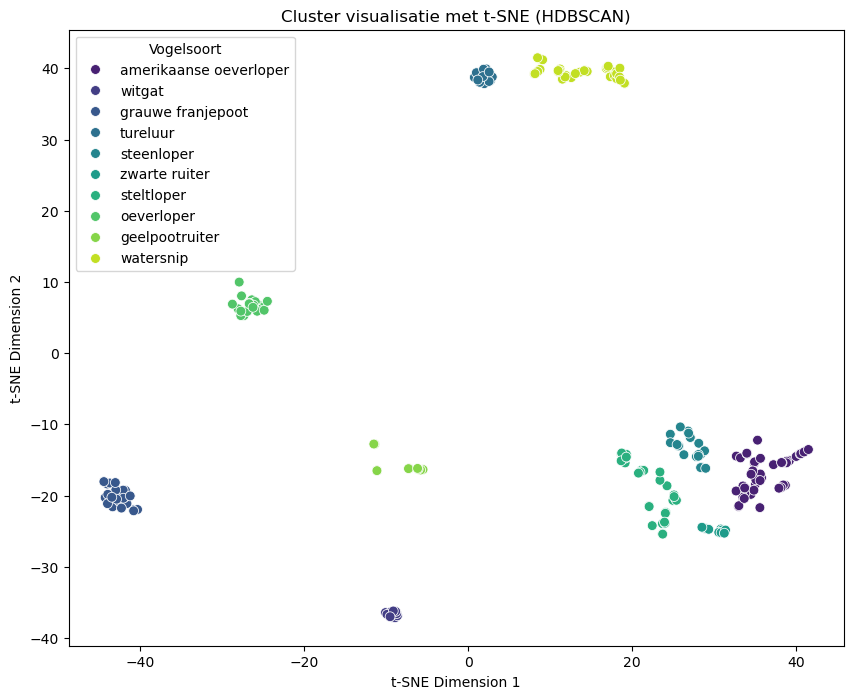

In [43]:
import hdbscan

# Pas HDBSCAN toe op de t-SNE features
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5, metric='euclidean')
hdbscan_labels = hdbscan_clusterer.fit_predict(features_tsne)

# Voeg de labels toe aan de dataset
species_labels_hdbscan = [cluster_to_species[label] if label in cluster_to_species else 'Onbekend' for label in hdbscan_labels]

# Filter de gegevens om "Onbekend" te verwijderen
filtered_indices_hdbscan = [i for i, label in enumerate(species_labels_hdbscan) if label != 'Onbekend']
filtered_features_tsne_hdbscan = features_tsne[filtered_indices_hdbscan]
filtered_species_labels_hdbscan = [species_labels_hdbscan[i] for i in filtered_indices_hdbscan]

# Plot de clusters zonder "Onbekend"
plt.figure(figsize=(10, 8))
sns.scatterplot(x=filtered_features_tsne_hdbscan[:, 0], y=filtered_features_tsne_hdbscan[:, 1], hue=filtered_species_labels_hdbscan, palette='viridis', s=50)
plt.title("Cluster visualisatie met t-SNE (HDBSCAN)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Vogelsoort", loc='best')
plt.show()

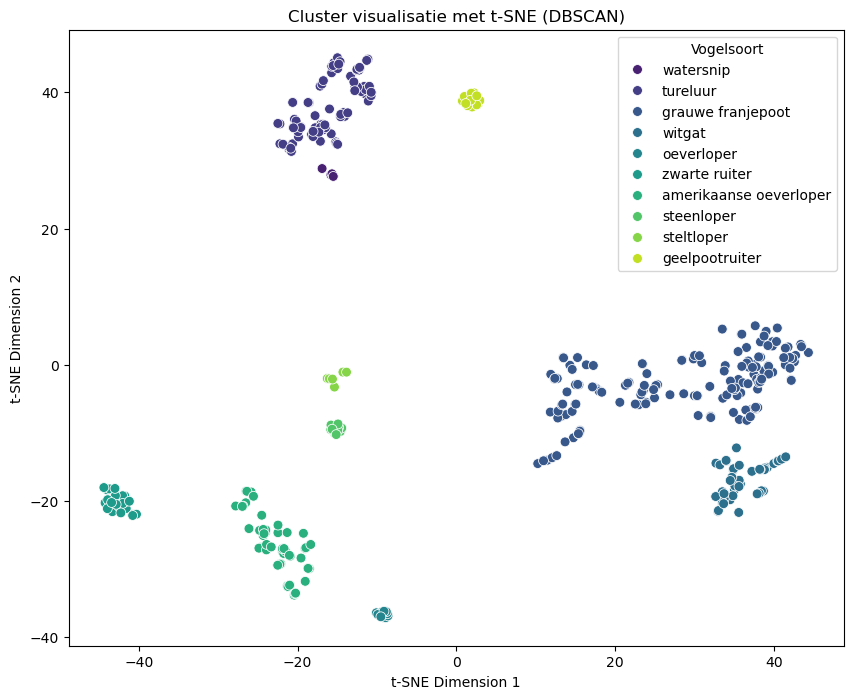

In [44]:
from sklearn.cluster import DBSCAN

# Pas DBSCAN toe op de t-SNE features
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_tsne)

# Voeg de labels toe aan de dataset
species_labels = [cluster_to_species[label] if label in cluster_to_species else 'Onbekend' for label in dbscan_labels]

# Filter de gegevens om "Onbekend" te verwijderen
filtered_indices = [i for i, label in enumerate(species_labels) if label != 'Onbekend']
filtered_features_tsne = features_tsne[filtered_indices]
filtered_species_labels = [species_labels[i] for i in filtered_indices]

# Plot de clusters zonder "Onbekend"
plt.figure(figsize=(10, 8))
sns.scatterplot(x=filtered_features_tsne[:, 0], y=filtered_features_tsne[:, 1], hue=filtered_species_labels, palette='viridis', s=50)
plt.title("Cluster visualisatie met t-SNE (DBSCAN)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Vogelsoort", loc='best')
plt.show()


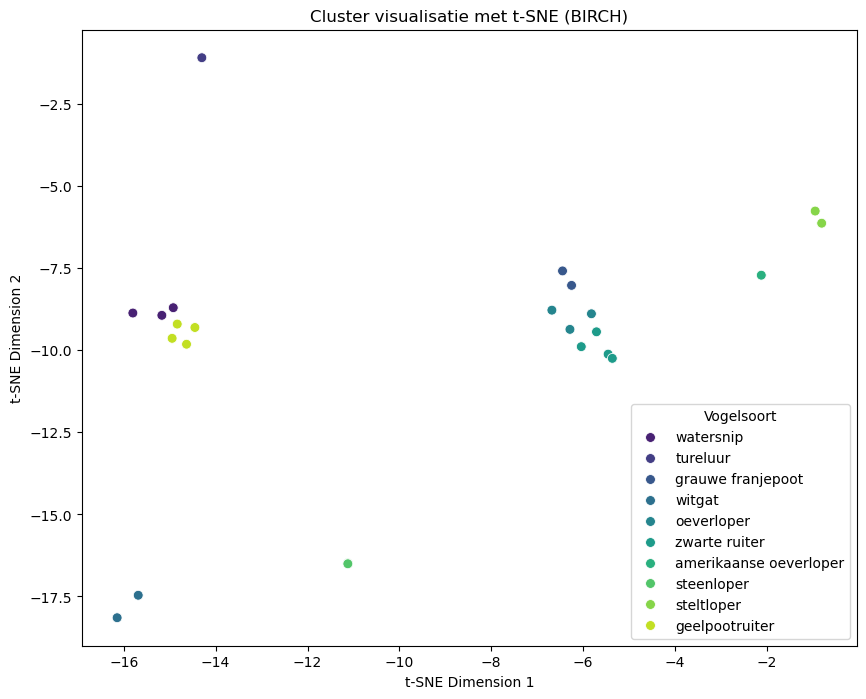

In [36]:
from sklearn.cluster import Birch

# Pas BIRCH toe op de t-SNE features
birch_clusterer = Birch(n_clusters=None, threshold=0.5)
birch_labels = birch_clusterer.fit_predict(features_tsne)

# Voeg de labels toe aan de dataset
species_labels_birch = [cluster_to_species[label] if label in cluster_to_species else 'Onbekend' for label in birch_labels]

# Filter de gegevens om "Onbekend" te verwijderen
filtered_indices_birch = [i for i, label in enumerate(species_labels_birch) if label != 'Onbekend']
filtered_features_tsne_birch = features_tsne[filtered_indices_birch]
filtered_species_labels_birch = [species_labels_birch[i] for i in filtered_indices_birch]

# Plot de clusters zonder "Onbekend"
plt.figure(figsize=(10, 8))
sns.scatterplot(x=filtered_features_tsne_birch[:, 0], y=filtered_features_tsne_birch[:, 1], hue=filtered_species_labels_birch, palette='viridis', s=50)
plt.title("Cluster visualisatie met t-SNE (BIRCH)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Vogelsoort", loc='best')
plt.show()